
# ДЗ №2 СМ. В КОНЦЕ НОУТБУКА



## Практика

In [47]:
import numpy as np
import random

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)

## Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [5]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 147MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 9.56MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 32.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.74MB/s]


In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

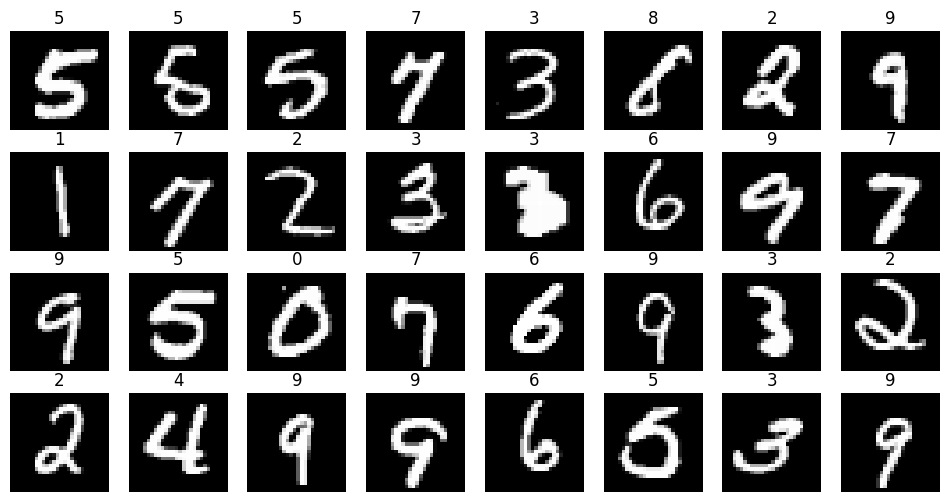

In [7]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## MNIST

In [8]:
X[0].shape

(1, 28, 28)

In [9]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [10]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.320/0.316	Accuracy: 0.916/0.917

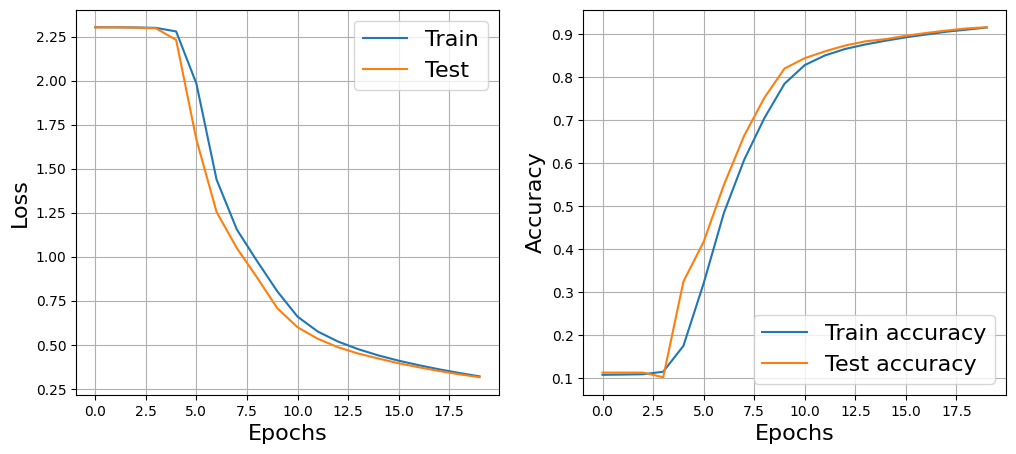

In [11]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [12]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.086	Accuracy: 0.990/0.973

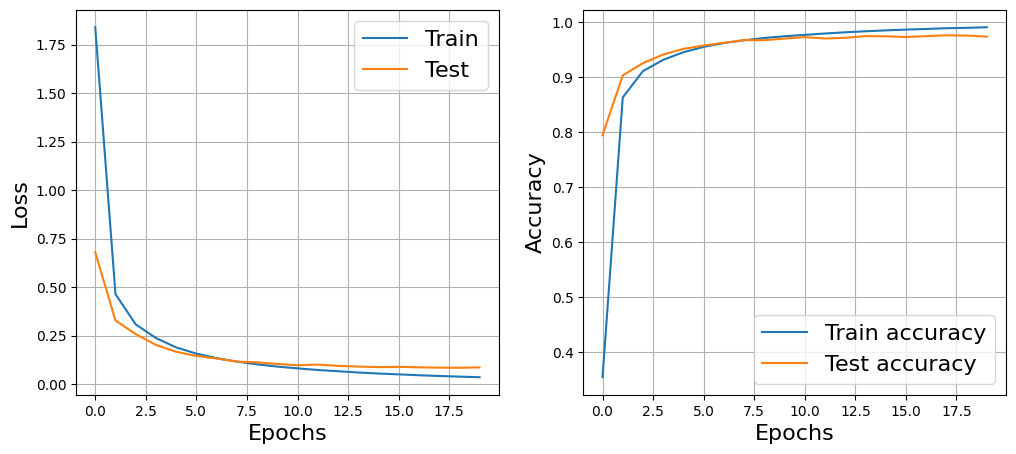

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.083	Accuracy: 0.987/0.975

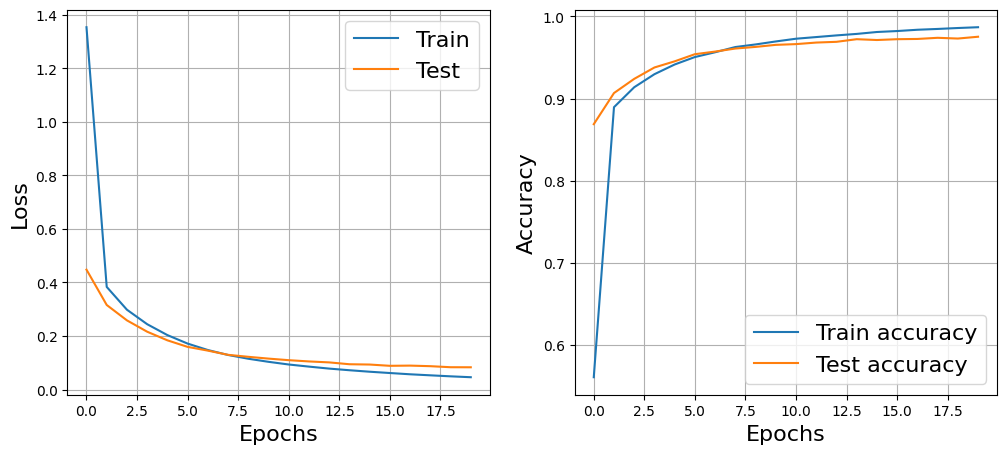

In [14]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

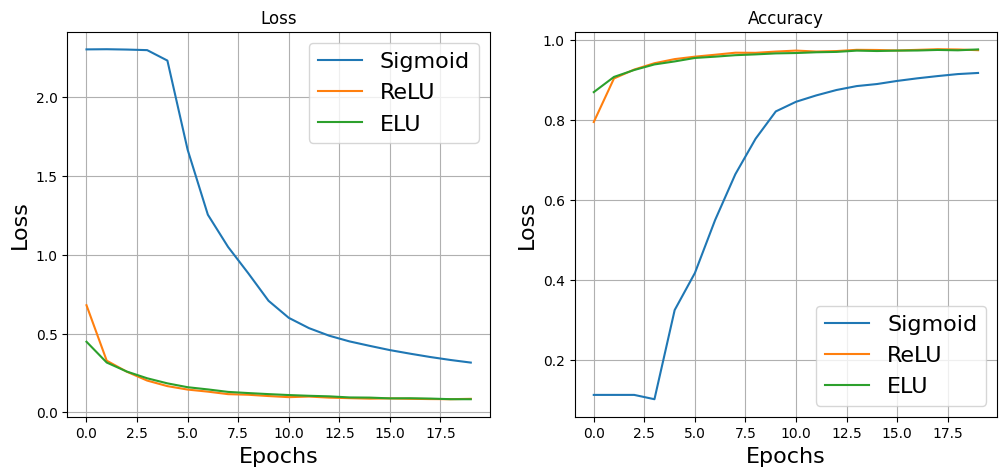

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

## Анализ ошибок

In [16]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

/tmp/ipython-input-1661168083.py:17: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  wrong_X = np.row_stack(wrong_X)
/tmp/ipython-input-1661168083.py:18: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  correct_y = np.row_stack(correct_y)[:, 0]
/tmp/ipython-input-1661168083.py:19: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  predicted_y = np.row_stack(predicted_y)[:, 0]
/tmp/ipython-input-1661168083.py:20: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  logits = np.row_stack(logits)[:, 0]


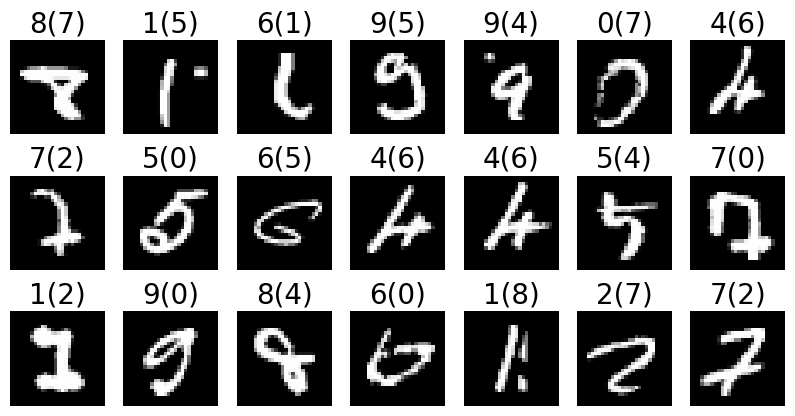

In [17]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 1: Реализовать Tanh

Реализуем функцию активации

In [26]:
import numpy as np

class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        self.X = X
        self.tan = np.tanh(X)
        return self.tan

    def backward(self, dLdy):
        dydX = 1 - self.tan**2
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Обучим модели с различными функциями активации и сравним результат

Epoch 9... (Train/Test) NLL: 0.081/0.098	Accuracy: 0.978/0.970

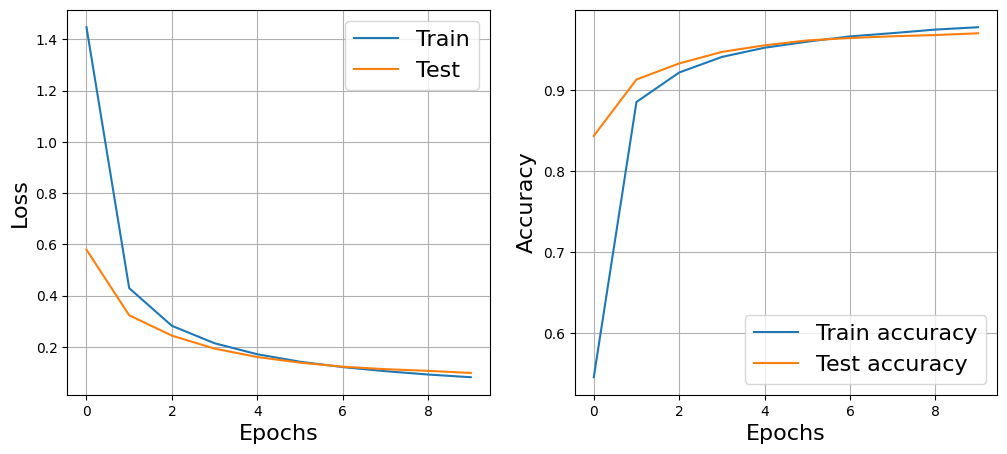

In [19]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 10, 0.01)

network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.01)

network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 10, 0.01)

network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 10, 0.01)

Построим графики для всех обученных моделей

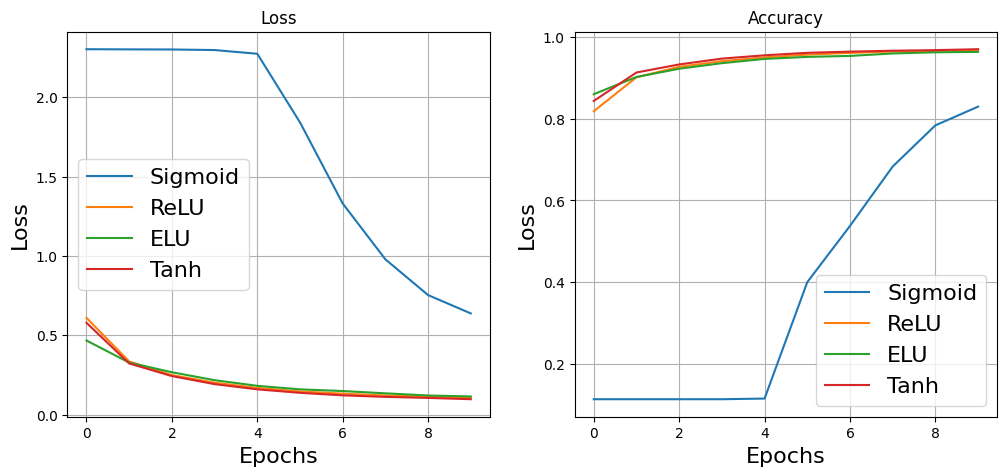

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Вывод: При использовании функции активации гиперболиеский тангенс качество предсказания практически не отличается от relu и elu

## Задание 2: Аугментации

Напишем функцию, которая запускает обучение нейронной сети с различными начальными преобразованиями

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms

# Класс для добавления шума (Взял с лекции)
class Noise:
    def __init__(self, mean=0., stddev=0.1):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, stddev={self.stddev})"


# Определим несколько пайплайнов трансформаций
base_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Пайплайн с поворотом
rot_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

#Пайплайн со сдвигом
shift_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Добавление шума
noise_transforms = transforms.Compose([
    transforms.ToTensor(),
    Noise(mean=0., stddev=0.05),
])

# Все вместе
all_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    Noise(mean=0., stddev=0.05),
])


# Функция для обучения и проверки с разными трансформами
def run_experiment(train_transform, title, epochs=12, lr=0.01):
    loss = NLLLoss()

    train_dataset = torchvision.datasets.MNIST(
        '.', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.MNIST(
        '.', train=False, download=True, transform=transforms.ToTensor()
    )
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Взял функцию активации гиперболический тангенс
    network = NeuralNetwork([
        Linear(784, 100), Tanh(),
        Linear(100, 100), Tanh(),
        Linear(100, 10)
    ])

    # Запуск обучения
    tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, epochs, lr)

    # Графики
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(tr_s, label="train loss")
    plt.plot(ts_s, label="test loss")
    plt.title(f"Loss - {title}")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(tr_ac_s, label="train acc")
    plt.plot(ts_ac_s, label="test acc")
    plt.title(f"Accuracy - {title}")
    plt.legend()
    plt.show()

    return ts_ac_s[-1]  # финальная accuracy на тесте


Проведем эксперимент для каждого преобразования

In [55]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Epoch 11... (Train/Test) NLL: 0.065/0.088	Accuracy: 0.983/0.972

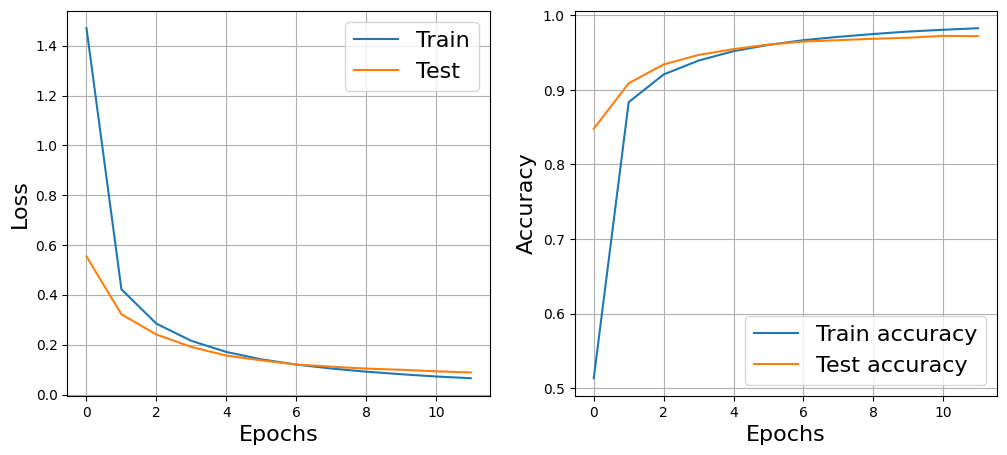

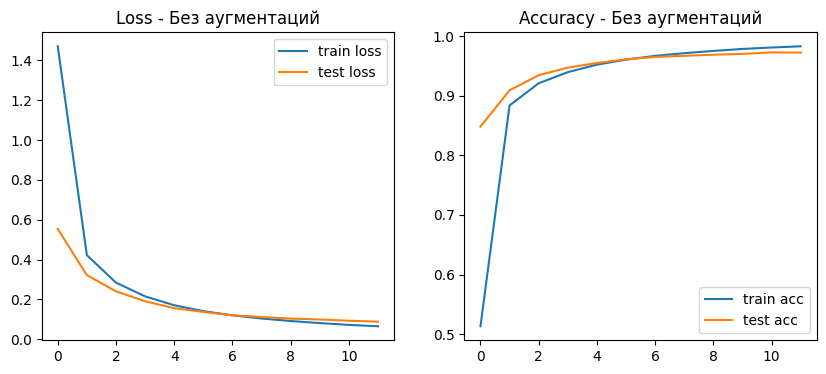

np.float64(0.9721445686900958)

In [56]:
run_experiment(base_transforms, "Без аугментаций")

Epoch 11... (Train/Test) NLL: 0.068/0.095	Accuracy: 0.982/0.972

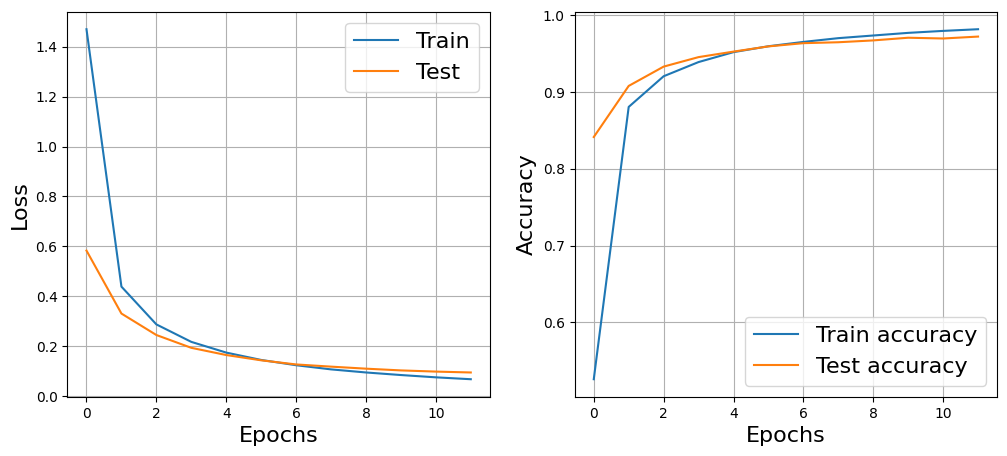

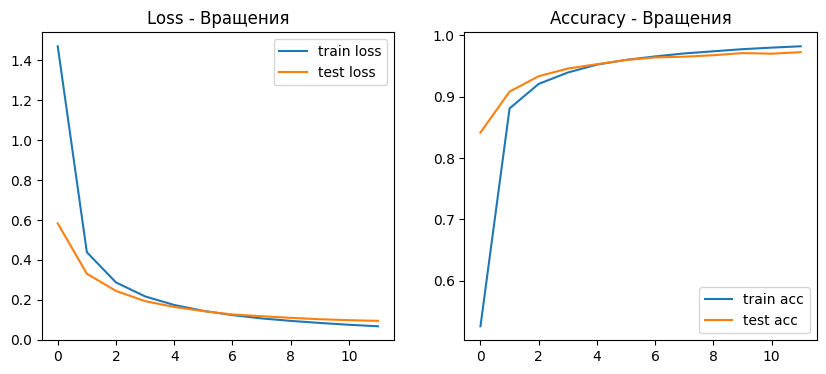

np.float64(0.972444089456869)

In [57]:
run_experiment(rot_transforms, "Вращения")

Epoch 11... (Train/Test) NLL: 0.065/0.090	Accuracy: 0.983/0.973

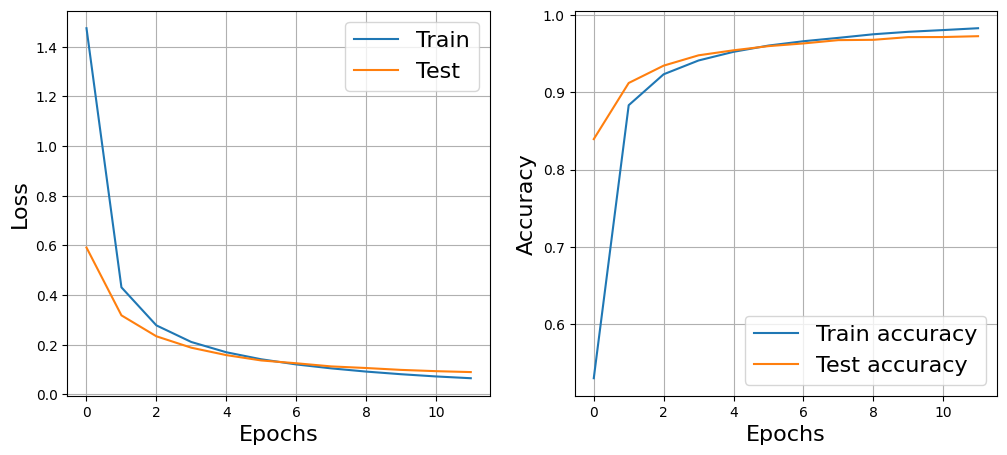

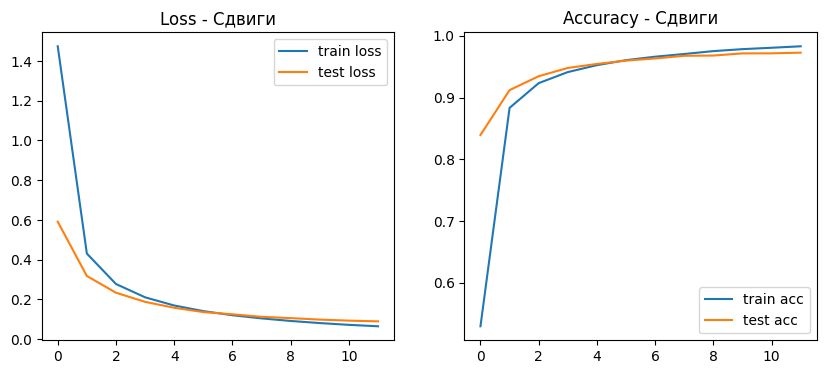

np.float64(0.9726437699680511)

In [58]:
run_experiment(shift_transforms, "Сдвиги")

Epoch 11... (Train/Test) NLL: 0.064/0.090	Accuracy: 0.984/0.972

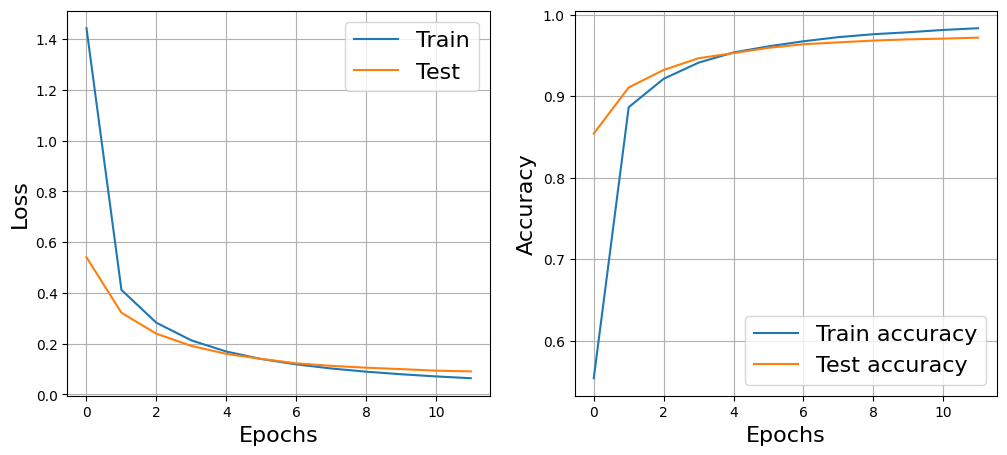

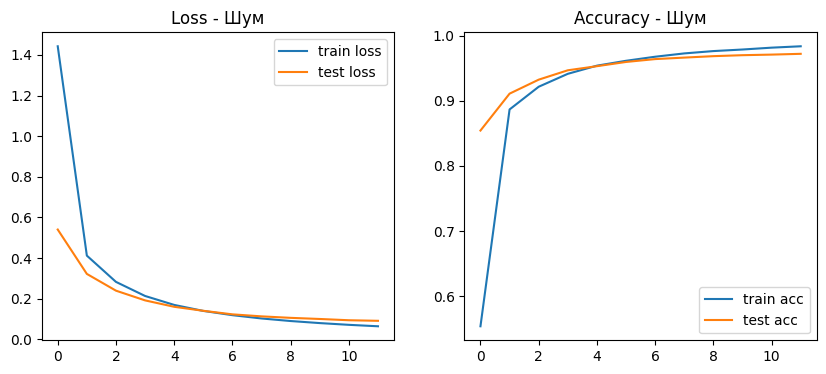

np.float64(0.9719448881789138)

In [59]:
run_experiment(noise_transforms, "Шум")

Epoch 11... (Train/Test) NLL: 0.067/0.090	Accuracy: 0.982/0.973

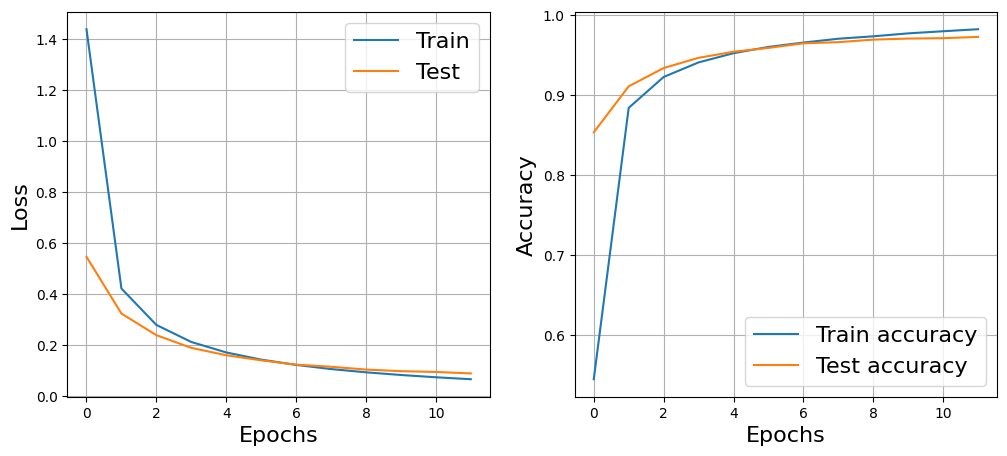

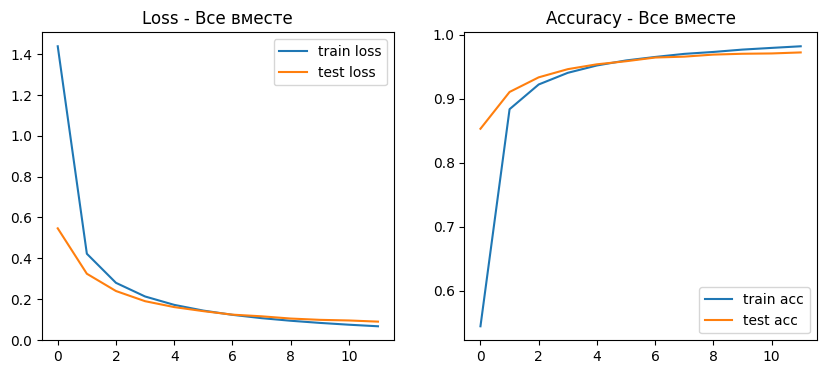

np.float64(0.9726437699680511)

In [60]:
run_experiment(all_transforms, "Все вместе")

Вывод: применение различных типов аугментации улучшают качество предсказания (хотя на этом эксперименте это заметно только на 4 цифре после нуля)